In [35]:
# Standard library imports
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import time

# Third-party library imports
import cv2
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba

# SciPy ecosystem imports
from scipy import ndimage
from scipy.ndimage import gaussian_filter, distance_transform_edt
from scipy.spatial import distance_matrix
from scipy.stats import gaussian_kde
from scipy.ndimage import uniform_filter, gaussian_filter
from skimage import exposure, morphology

# Scikit-image imports
from skimage import measure
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# Segment Anything Model imports
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P /kaggle/working/

checkpoint_path = "/kaggle/working/sam_vit_h_4b8939.pth"
if os.path.exists(checkpoint_path):
    print(f"✓ Downloaded successfully: {os.path.getsize(checkpoint_path) / (1024**3):.2f} GB")
else:
    print("✗ Download failed")

--2025-09-02 09:07:23--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.158.20.21, 108.158.20.43, 108.158.20.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.158.20.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/kaggle/working/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   417MB/s    in 5.7s    

2025-09-02 09:07:29 (426 MB/s) - ‘/kaggle/working/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

✓ Downloaded successfully: 2.39 GB


In [3]:
def show_image(path):
    yeast_sample = cv2.imread(path)
    yeast_sample = cv2.cvtColor(yeast_sample, cv2.COLOR_BGR2RGB)
    plt.figure(figsize= (10,10))
    plt.imshow(yeast_sample)
    plt.axis(False)
    plt.show()

def create_circular_mask_simple(image_gray, threshold=15):
    mask = image_gray > threshold
    mask = ndimage.binary_fill_holes(mask)
    
    print(f"✅ Circular mask created: {np.sum(mask)} valid pixels ({np.sum(mask)/mask.size*100:.1f}%)")
    return mask

def apply_mask_to_detections(masks, circular_mask, min_overlap=0.5):
    filtered_masks = []
    removed = 0
    
    for mask in masks:
        overlap = mask & circular_mask
        overlap_ratio = np.sum(overlap) / np.sum(mask) if np.sum(mask) > 0 else 0
        
        if overlap_ratio >= min_overlap:
            cleaned_mask = mask & circular_mask
            if np.sum(cleaned_mask) > 50:  
                filtered_masks.append(cleaned_mask)
            else:
                removed += 1
        else:
            removed += 1
    
    print(f"🚫 Removed {removed} detections outside circular area")
    return filtered_masks

def resize_image(image, max_dimension=1024):
    height, width = image.shape[:2]

    if max(height, width) <= max_dimension:
        return image
    
    if height > width:
        new_height = max_dimension
        new_width = int((width / height) * max_dimension)
    else:
        new_width = max_dimension
        new_height = int((height / width) * max_dimension)
        
    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized

In [45]:
class YeastDetector:
    
    def __init__(self, model_type="vit_h", average_cell_area=None, variance_threshold_factor=0.4, window_size=5):
        
        checkpoint_path = "/kaggle/working/sam_vit_h_4b8939.pth"
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
        self.sam.to(device=device)
        
        self.cell_mask_generator = SamAutomaticMaskGenerator(
            model=self.sam,
            points_per_side=64,
            pred_iou_thresh=0.7,
            stability_score_thresh=0.8,
            min_mask_region_area=100,
        )
        self.average_cell_area = average_cell_area
        self.variance_threshold_factor = variance_threshold_factor
        self.window_size = window_size
        
    def _compute_local_variance(self, image):
        """
        Computes a local variance map for the image efficiently using uniform filters.
        """
        img_float = image.astype(np.float64)
        mean = uniform_filter(img_float, size=self.window_size)
        sq_mean = uniform_filter(img_float**2, size=self.window_size)
        raw_variance = sq_mean - mean**2
        return raw_variance

    def _filter_masks_by_variance(self, masks, image_gray):
        """
        Filters masks by removing those with low internal variance, likely artifacts.
        """
        if not masks:
            return []

        variance_map = self._compute_local_variance(image_gray)
        
        mask_variances = []
        for mask in masks:
            avg_variance = np.mean(variance_map[mask]) if np.any(mask) else 0
            mask_variances.append(avg_variance)
        
        variance_threshold = np.mean(mask_variances) * self.variance_threshold_factor
        filtered_masks = [mask for i, mask in enumerate(masks) if mask_variances[i] > variance_threshold]
        
        removed_count = len(masks) - len(filtered_masks)
        print(f"  └─ Filtered {removed_count} artifacts based on a variance threshold of {variance_threshold:.2f}")
        
        return filtered_masks

    def compute_circularity_heatmap(self, masks, image_shape, strictness=2.0):
        """
        Computes the circularity values for the masks
        """
        circ_map = np.zeros(image_shape, dtype=np.float32)
        scores = []
        for mask in masks:
            props = measure.regionprops(mask.astype(int))
            if not props:
                scores.append(0)
                continue
            prop = props[0]
            area, perimeter = prop.area, prop.perimeter
            if perimeter > 0:
                circularity = (4 * np.pi * area) / (perimeter ** 2)
                circularity = min(circularity, 1.0) ** strictness
            else:
                circularity = 0
            scores.append(circularity)
            circ_map[mask] = circularity
        return gaussian_filter(circ_map, sigma=3), scores

    def analyze(self, image_path):
        """
        Main function which is to be called for the Analysis
        """
        image = resize_image(cv2.imread(image_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        circular_mask = create_circular_mask_simple(image_gray)
        
        print("🔵 STEP 1: Individual Yeast Detection")
        with torch.inference_mode():
            cell_masks_data = self.cell_mask_generator.generate(image_rgb)
        
        initial_masks = [m['segmentation'] for m in cell_masks_data if 100 < m['area']]
        initial_masks = apply_mask_to_detections(initial_masks, circular_mask)
        print(f"  └─ Found {len(initial_masks)} initial candidates.")

        print("🔶 STEP 2: Filtering Low-Variance Artifacts")
        masks = self._filter_masks_by_variance(initial_masks, image_gray)
                
        print("🔍 STEP 3: Computing Metrics for Valid Cells")
        circularity_heatmap, circularity_scores = self.compute_circularity_heatmap(
            masks, image_gray.shape
        )
        
        if masks:
            cell_areas = [np.sum(mask) for mask in masks]
            self.average_cell_area = np.mean(cell_areas)
        else:
            cell_areas = [0]
            self.average_cell_area = 0
        total_cells = len(masks)
        
        print("\n" + "="*50)
        print("📊 ANALYSIS REPORT")
        print("="*50)
        print("\n🔴 FINAL CELL DETECTION:")
        print(f"  ├─ Valid cells detected: {total_cells}")
        if total_cells > 0:
            print(f"  ├─ Average cell area: {self.average_cell_area:.0f} pixels")
            print(f"  └─ Cell area range: {min(cell_areas):.0f} - {max(cell_areas):.0f} pixels")
        else:
            print("  └─ No valid cells detected.")
        print(f"\n🔵 CELL SHAPE QUALITY (Circularity):")
        if circularity_scores and total_cells > 0:
            excellent_cells = sum(1 for score in circularity_scores if score >= 0.8)
            good_cells = sum(1 for score in circularity_scores if 0.6 <= score < 0.8)
            poor_cells = sum(1 for score in circularity_scores if score < 0.6)
            
            print(f"  ├─ Mean circularity: {np.mean(circularity_scores):.3f}")
            print(f"  ├─ Std deviation: {np.std(circularity_scores):.3f}")
            print(f"  ├─ Excellent (≥0.8): {excellent_cells} cells ({excellent_cells/total_cells*100:.1f}%)")
            print(f"  ├─ Good (0.6-0.8): {good_cells} cells ({good_cells/total_cells*100:.1f}%)")
            print(f"  └─ Poor (<0.6): {poor_cells} cells ({poor_cells/total_cells*100:.1f}%)")
        else:
            print(f"  └─ No circularity data available.")
        print("\n" + "="*50)
        
        self.plot_analysis_results(image_gray, masks, circularity_heatmap)
        
        return {
            'image': image_gray,
            'masks': masks,
            'cell_count': total_cells,
            'average_cell_area': self.average_cell_area,
            'cell_area_range': (min(cell_areas), max(cell_areas)) if masks else (0, 0),
            'circularity_scores': circularity_scores,
            'circularity_heatmap': circularity_heatmap
        }
    
    def plot_analysis_results(self, image_gray, masks, circularity_heatmap):
        fig, axs = plt.subplots(3, 1, figsize=(8, 24))
        axs[0].imshow(image_gray, cmap='gray')
        axs[0].set_title("1. Original Grayscale Image", fontsize=20, fontweight='bold')
        axs[0].axis('off')
        axs[1].imshow(image_gray, cmap='gray')
        if masks:
            mask_overlay = np.zeros((*image_gray.shape, 4), dtype=np.float32)
            for mask in masks:
                mask_overlay[mask] = to_rgba('green', alpha=0.5)
            axs[1].imshow(mask_overlay)
        axs[1].set_title(f"2. Detected Cells ({len(masks)} found)", fontsize=20, fontweight='bold')
        axs[1].axis('off')
        axs[2].imshow(image_gray, cmap='gray')
        im = axs[2].imshow(circularity_heatmap, cmap='inferno', alpha=0.7)
        axs[2].set_title("3. Circularity Heatmap", fontsize=20, fontweight='bold')
        axs[2].axis('off')
        fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04).set_label("Circularity Score", fontsize=16)
        plt.tight_layout()
        plt.show()

In [65]:
def morphological_classification(analysis_results, 
                                 threshold_1=0.1, 
                                 threshold_2=0.5, 
                                 class_name_1="Pseudohyphae",
                                 class_name_2="Germ Tubes / Aggregated Yeast Cells",
                                 class_name_3="Round Yeast Cells"):
    """
    Classifies masks into three categories based on circularity and visualizes the results.

    Args:
        analysis_results (dict): The dictionary returned by the YeastDetector's analyze method.
        threshold_1 (float): The lower circularity threshold.
        threshold_2 (float): The upper circularity threshold.
        class_name_1 (str): Name for the lowest circularity class.
        class_name_2 (str): Name for the middle circularity class.
        class_name_3 (str): Name for the highest circularity class.

    Returns:
        dict: A dictionary containing the lists of three classes of masks.
    """
    image_gray = analysis_results['image']
    masks = analysis_results['masks']
    circularity_scores = analysis_results['circularity_scores']
    
    class_1_masks = []
    class_2_masks = []
    class_3_masks = []
    
    for mask, score in zip(masks, circularity_scores):
        if score < threshold_1:
            class_1_masks.append(mask)
        elif threshold_1 <= score < threshold_2:
            class_2_masks.append(mask)
        else:
            class_3_masks.append(mask)
            
    print("\n--- Morphological Classification (3 Classes) ---")
    print(f"{class_name_1} (Circularity < {threshold_1}): {len(class_1_masks)} cells")
    print(f"{class_name_2} ({threshold_1} <= Circularity < {threshold_2}): {len(class_2_masks)} cells")
    print(f"{class_name_3} (Circularity >= {threshold_2}): {len(class_3_masks)} cells")
    print("-------------------------------------------------")
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image_gray, cmap='gray')
    
    color_1 = 'blue'
    color_2 = 'orange'
    color_3 = 'green'
    
    if class_1_masks:
        overlay_1 = np.zeros((*image_gray.shape, 4), dtype=np.float32)
        for mask in class_1_masks:
            overlay_1[mask] = to_rgba(color_1, alpha=0.6)
        ax.imshow(overlay_1)

    if class_2_masks:
        overlay_2 = np.zeros((*image_gray.shape, 4), dtype=np.float32)
        for mask in class_2_masks:
            overlay_2[mask] = to_rgba(color_2, alpha=0.6)
        ax.imshow(overlay_2)
        
    if class_3_masks:
        overlay_3 = np.zeros((*image_gray.shape, 4), dtype=np.float32)
        for mask in class_3_masks:
            overlay_3[mask] = to_rgba(color_3, alpha=0.6)
        ax.imshow(overlay_3)
        
    legend_patches = [
        mpatches.Patch(color=color_1, label=f'{class_name_1} ({len(class_1_masks)})'),
        mpatches.Patch(color=color_2, label=f'{class_name_2} ({len(class_2_masks)})'),
        mpatches.Patch(color=color_3, label=f'{class_name_3} ({len(class_3_masks)})')
    ]
    ax.legend(handles=legend_patches, loc='upper right', fontsize=12)
    
    ax.set_title("Morphological Classification of Yeast Cells", fontsize=18, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return {
        class_name_1: class_1_masks,
        class_name_2: class_2_masks,
        class_name_3: class_3_masks,
    }

✅ Circular mask created: 431762 valid pixels (54.9%)
🔵 STEP 1: Individual Yeast Detection
🚫 Removed 6 detections outside circular area
  └─ Found 424 initial candidates.
🔶 STEP 2: Filtering Low-Variance Artifacts
  └─ Filtered 49 artifacts based on a variance threshold of 157.11
🔍 STEP 3: Computing Metrics for Valid Cells

📊 ANALYSIS REPORT

🔴 FINAL CELL DETECTION:
  ├─ Valid cells detected: 375
  ├─ Average cell area: 408 pixels
  └─ Cell area range: 109 - 2449 pixels

🔵 CELL SHAPE QUALITY (Circularity):
  ├─ Mean circularity: 0.835
  ├─ Std deviation: 0.200
  ├─ Excellent (≥0.8): 285 cells (76.0%)
  ├─ Good (0.6-0.8): 49 cells (13.1%)
  └─ Poor (<0.6): 41 cells (10.9%)



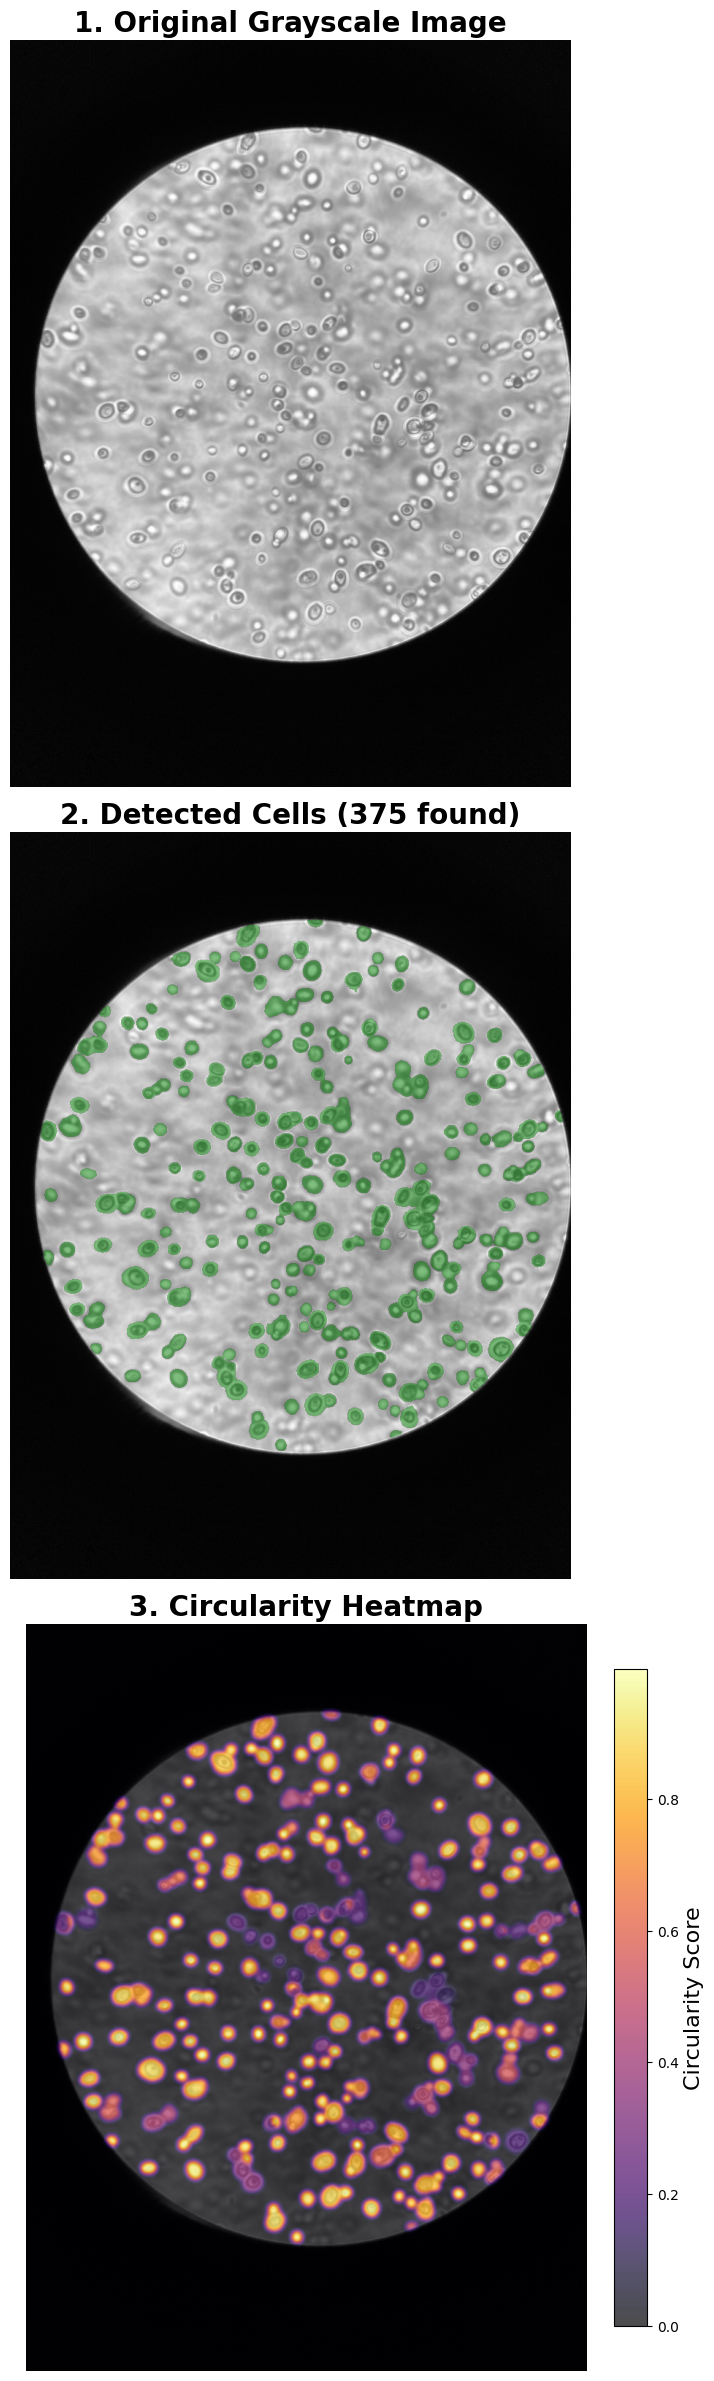

In [66]:
image_path = "/kaggle/input/candida/Candida Albicans/yeast/20240616_y.jpg"
analyzer = YeastDetector()
results = analyzer.analyze(image_path)


--- Morphological Classification (3 Classes) ---
Pseudohyphae (Circularity < 0.1): 0 cells
Germ Tubes / Aggregated Yeast Cells (0.1 <= Circularity < 0.5): 34 cells
Round Yeast Cells (Circularity >= 0.5): 341 cells
-------------------------------------------------


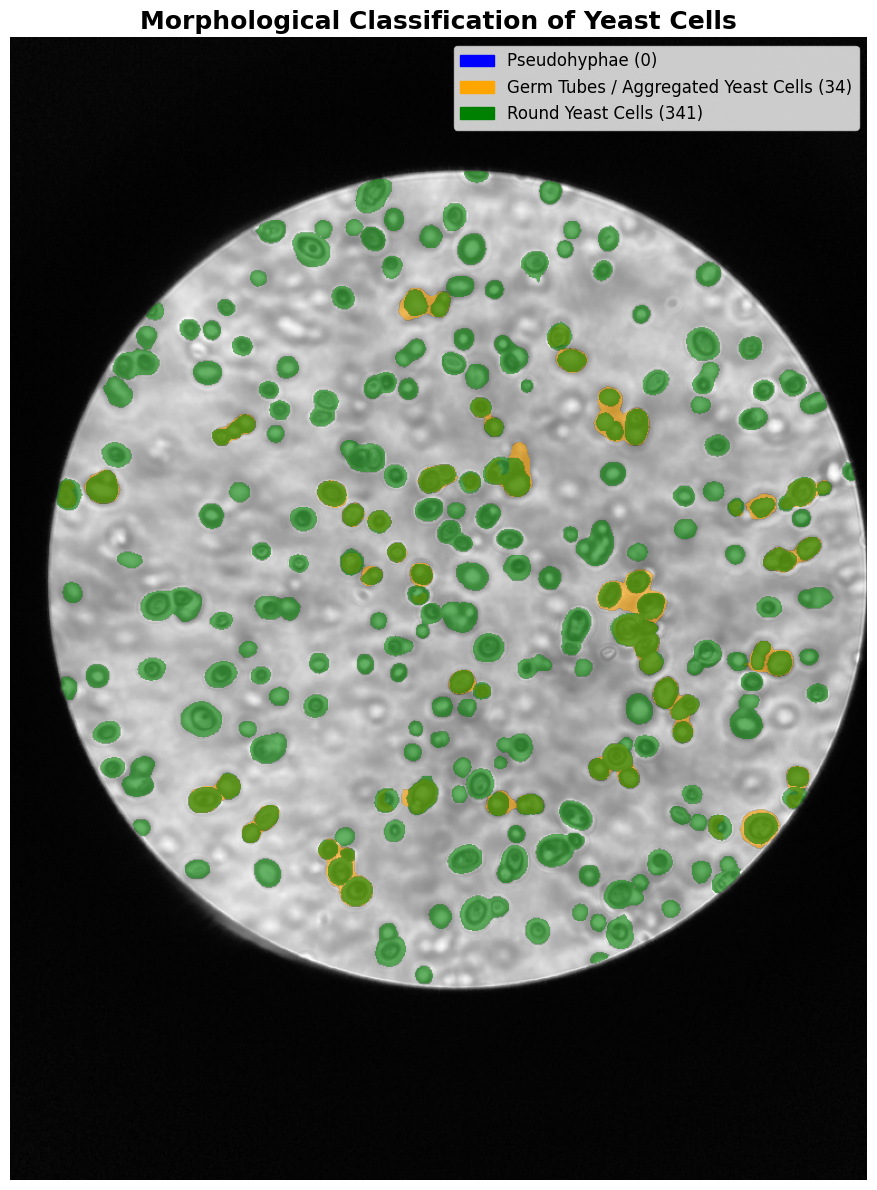

In [67]:
yeast, germ_tubes, pseudohyphae = morphological_classification(results)

✅ Circular mask created: 434134 valid pixels (55.2%)
🔵 STEP 1: Individual Yeast Detection
🚫 Removed 3 detections outside circular area
  └─ Found 149 initial candidates.
🔶 STEP 2: Filtering Low-Variance Artifacts
  └─ Filtered 17 artifacts based on a variance threshold of 259.04
🔍 STEP 3: Computing Metrics for Valid Cells

📊 ANALYSIS REPORT

🔴 FINAL CELL DETECTION:
  ├─ Valid cells detected: 132
  ├─ Average cell area: 640 pixels
  └─ Cell area range: 143 - 6709 pixels

🔵 CELL SHAPE QUALITY (Circularity):
  ├─ Mean circularity: 0.778
  ├─ Std deviation: 0.214
  ├─ Excellent (≥0.8): 86 cells (65.2%)
  ├─ Good (0.6-0.8): 28 cells (21.2%)
  └─ Poor (<0.6): 18 cells (13.6%)



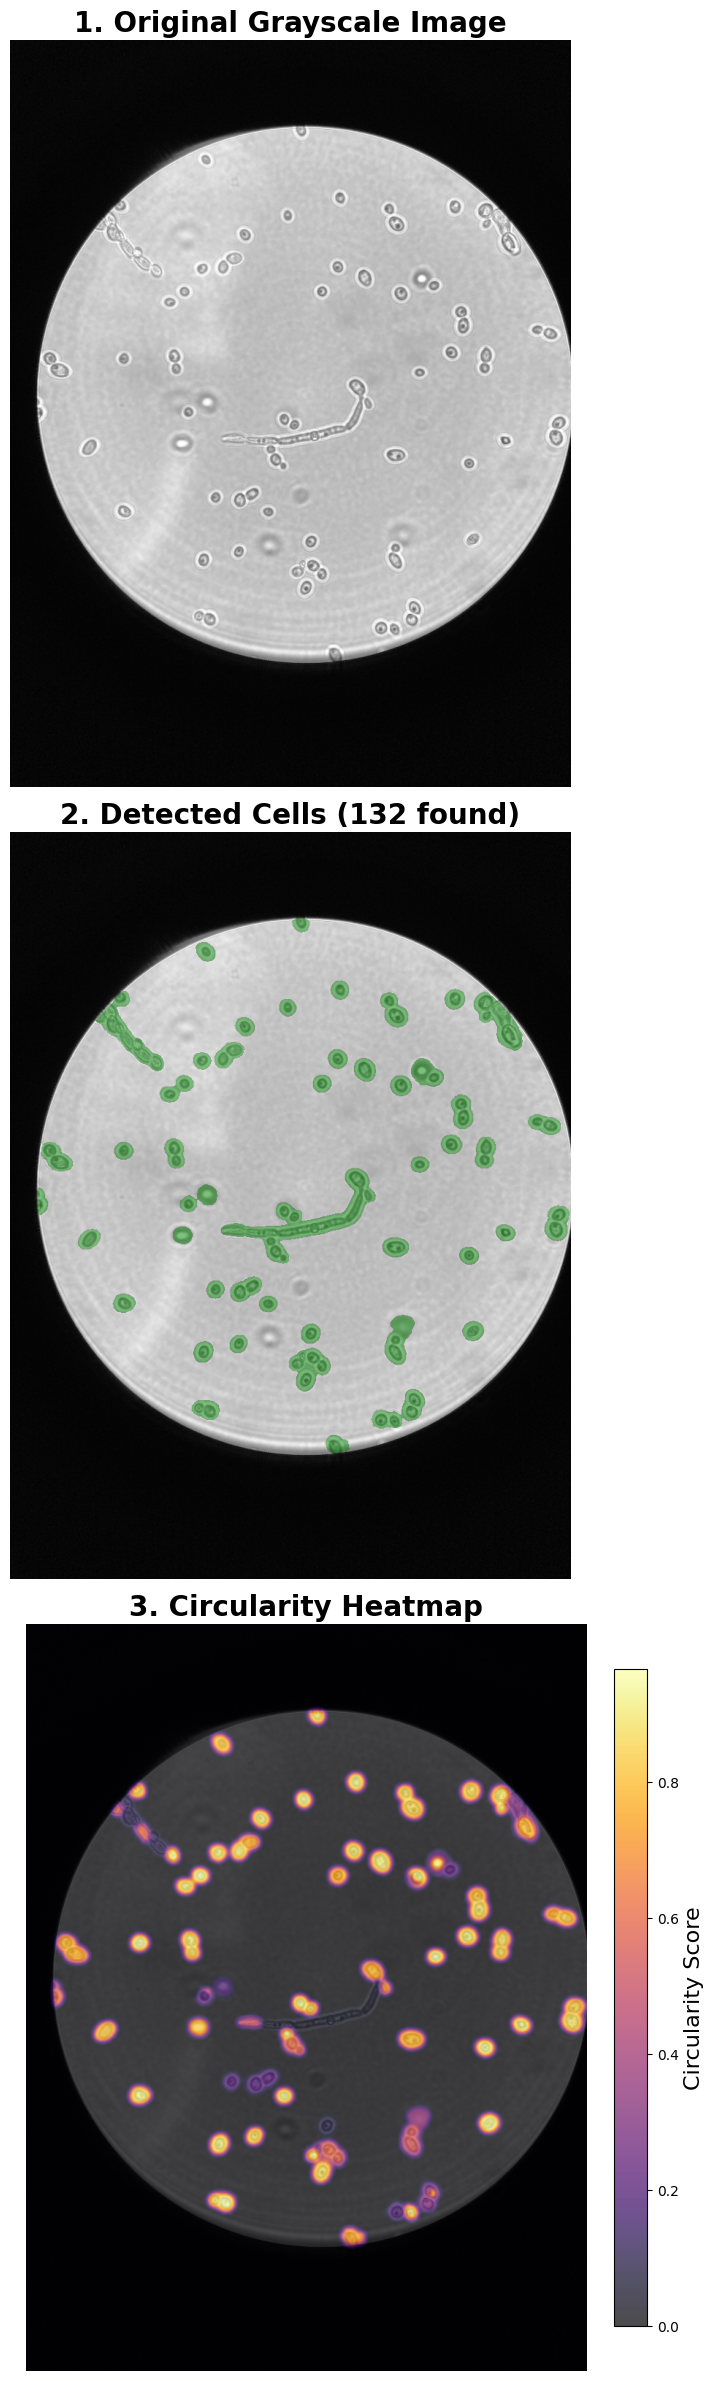

In [68]:
image_path = "/kaggle/input/candida/Candida Albicans/yeast_germ_pseudo/20240626_y_gt_ph_1.jpg"
analyzer = YeastDetector()
results = analyzer.analyze(image_path)


--- Morphological Classification (3 Classes) ---
Pseudohyphae (Circularity < 0.1): 3 cells
Germ Tubes / Aggregated Yeast Cells (0.1 <= Circularity < 0.5): 11 cells
Round Yeast Cells (Circularity >= 0.5): 118 cells
-------------------------------------------------


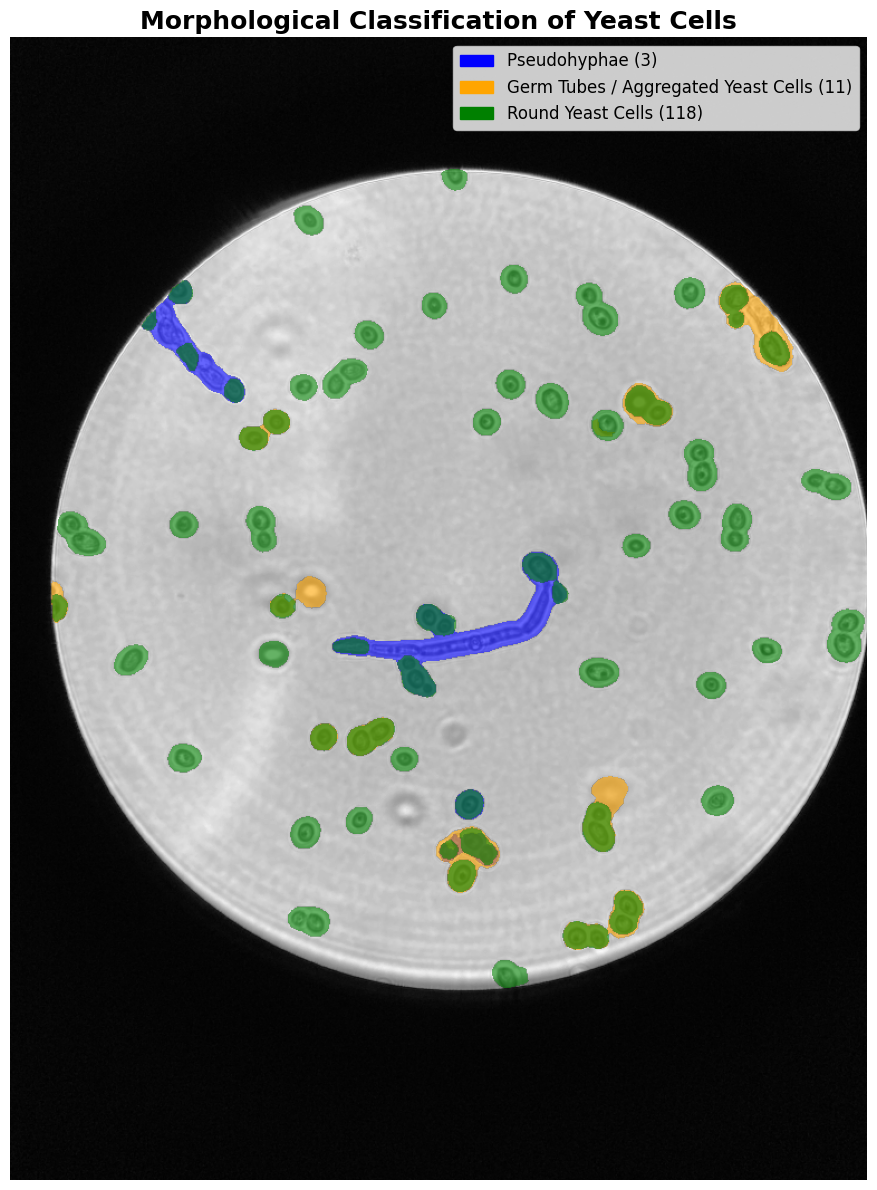

In [69]:
yeast, germ_tubes, pseudohyphae = morphological_classification(results)

Corrupt JPEG data: premature end of data segment


✅ Circular mask created: 426830 valid pixels (54.3%)
🔵 STEP 1: Individual Yeast Detection
🚫 Removed 6 detections outside circular area
  └─ Found 133 initial candidates.
🔶 STEP 2: Filtering Low-Variance Artifacts
  └─ Filtered 13 artifacts based on a variance threshold of 253.13
🔍 STEP 3: Computing Metrics for Valid Cells

📊 ANALYSIS REPORT

🔴 FINAL CELL DETECTION:
  ├─ Valid cells detected: 120
  ├─ Average cell area: 548 pixels
  └─ Cell area range: 121 - 4480 pixels

🔵 CELL SHAPE QUALITY (Circularity):
  ├─ Mean circularity: 0.776
  ├─ Std deviation: 0.235
  ├─ Excellent (≥0.8): 84 cells (70.0%)
  ├─ Good (0.6-0.8): 12 cells (10.0%)
  └─ Poor (<0.6): 24 cells (20.0%)



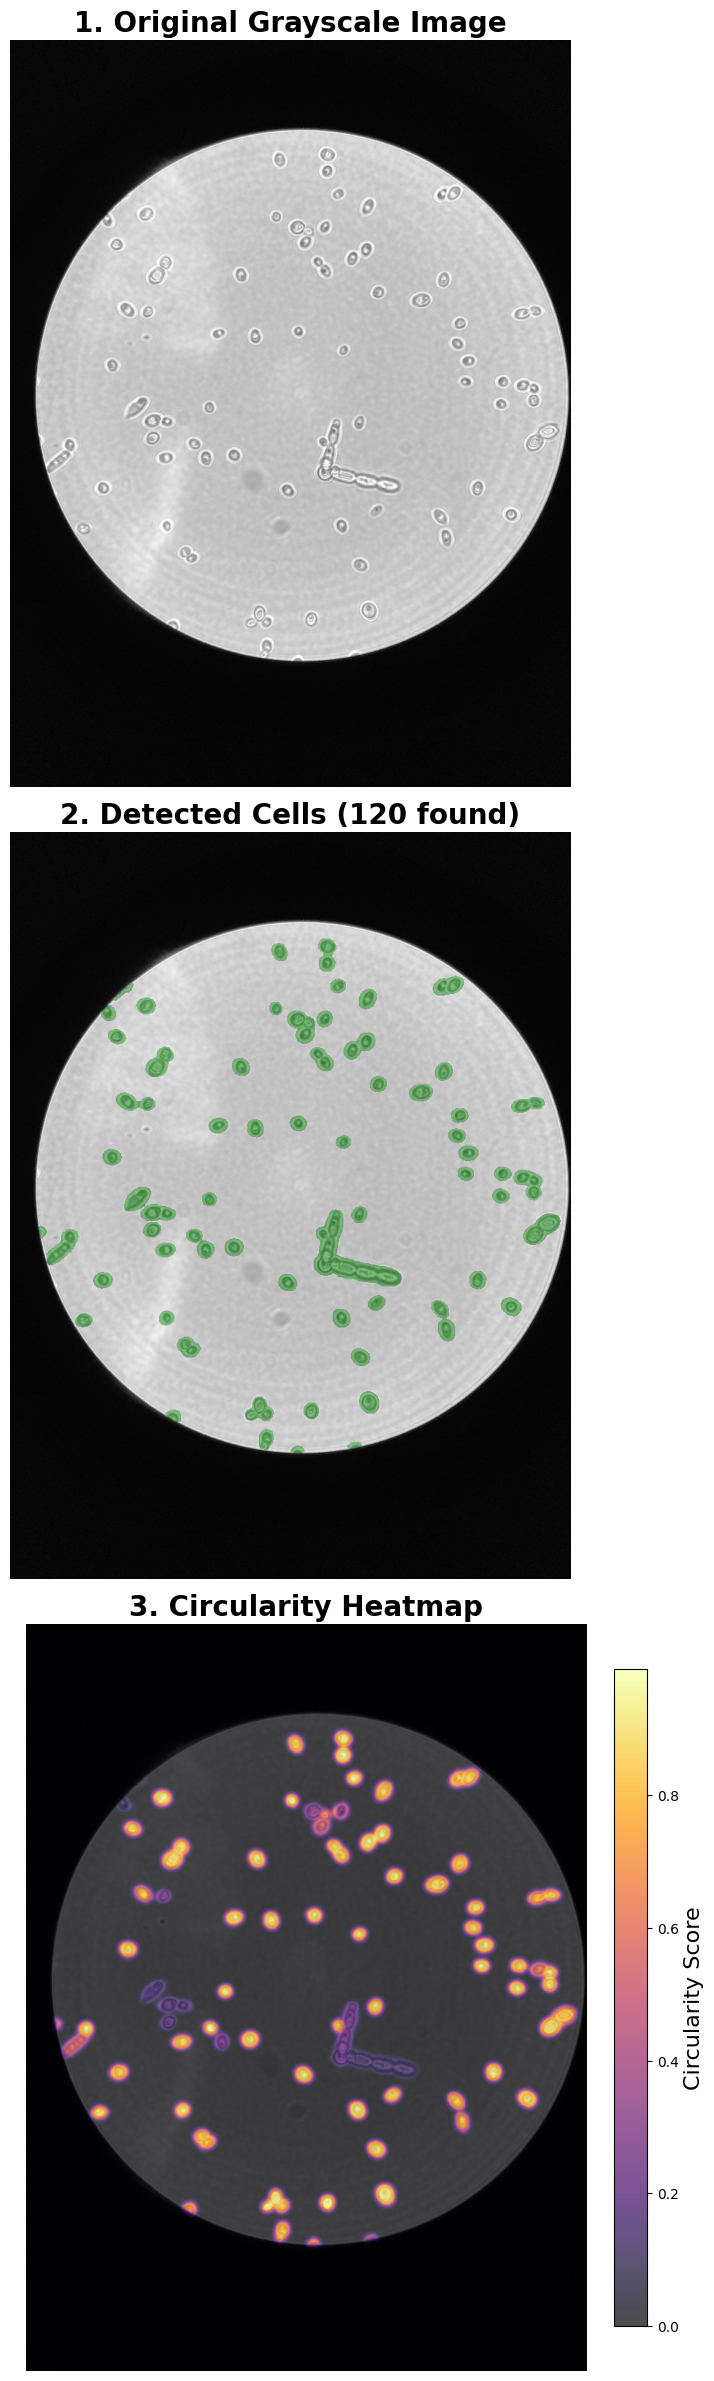

In [70]:
image_path = "/kaggle/input/candida/Candida Albicans/yeast_germ/20240623_y_gt_1.jpg"
analyzer = YeastDetector()
results = analyzer.analyze(image_path)


--- Morphological Classification (3 Classes) ---
Pseudohyphae (Circularity < 0.1): 1 cells
Germ Tubes / Aggregated Yeast Cells (0.1 <= Circularity < 0.5): 16 cells
Round Yeast Cells (Circularity >= 0.5): 103 cells
-------------------------------------------------


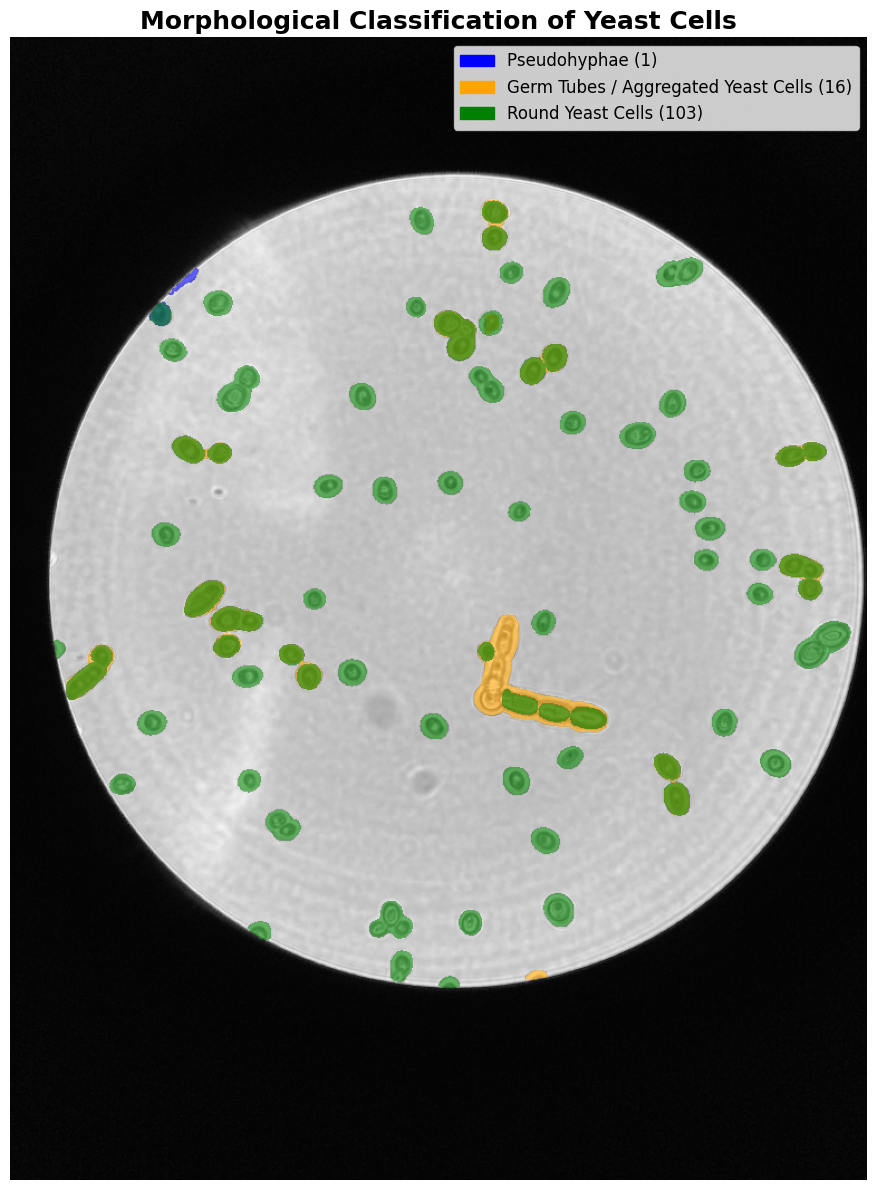

In [71]:
yeast, germ_tubes, pseudohyphae = morphological_classification(results)

Corrupt JPEG data: premature end of data segment


✅ Circular mask created: 407353 valid pixels (51.8%)
🔵 STEP 1: Individual Yeast Detection
🚫 Removed 4 detections outside circular area
  └─ Found 120 initial candidates.
🔶 STEP 2: Filtering Low-Variance Artifacts
  └─ Filtered 20 artifacts based on a variance threshold of 242.63
🔍 STEP 3: Computing Metrics for Valid Cells

📊 ANALYSIS REPORT

🔴 FINAL CELL DETECTION:
  ├─ Valid cells detected: 100
  ├─ Average cell area: 668 pixels
  └─ Cell area range: 159 - 5743 pixels

🔵 CELL SHAPE QUALITY (Circularity):
  ├─ Mean circularity: 0.798
  ├─ Std deviation: 0.207
  ├─ Excellent (≥0.8): 73 cells (73.0%)
  ├─ Good (0.6-0.8): 10 cells (10.0%)
  └─ Poor (<0.6): 17 cells (17.0%)



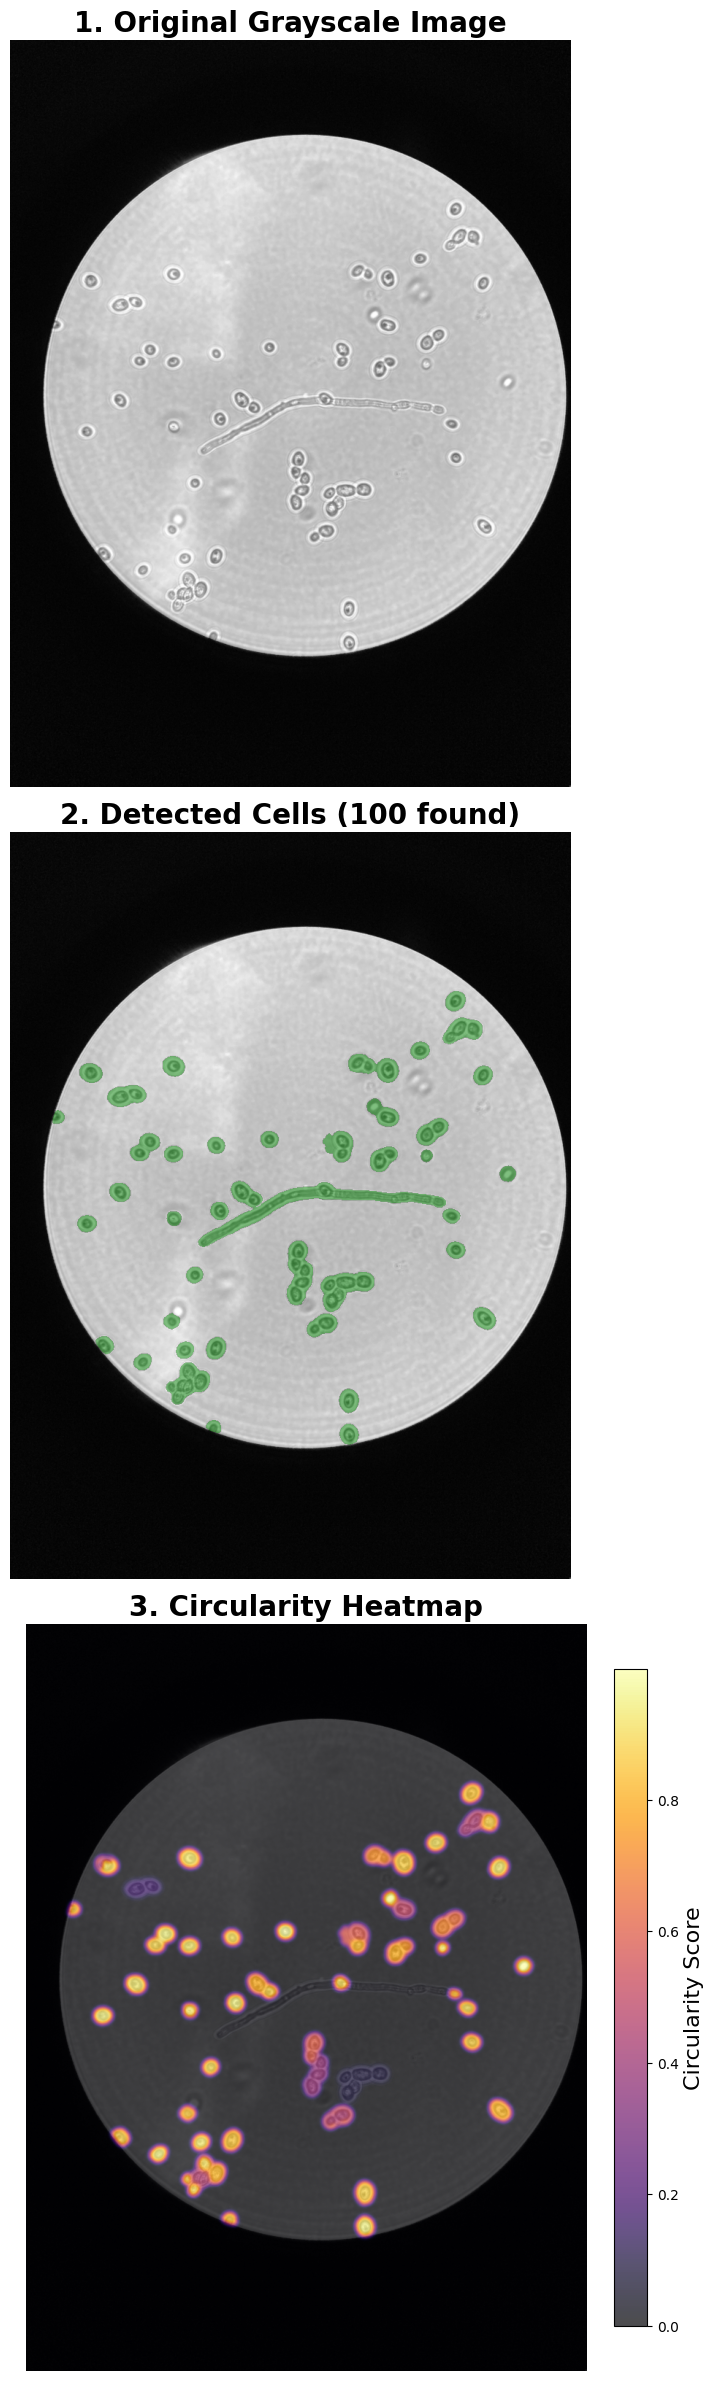

In [72]:
image_path = "/kaggle/input/candida/Candida Albicans/yeast_pseudo/20240626_y_ph_2.jpg"
analyzer = YeastDetector()
results = analyzer.analyze(image_path)


--- Morphological Classification (3 Classes) ---
Pseudohyphae (Circularity < 0.1): 2 cells
Germ Tubes / Aggregated Yeast Cells (0.1 <= Circularity < 0.5): 9 cells
Round Yeast Cells (Circularity >= 0.5): 89 cells
-------------------------------------------------


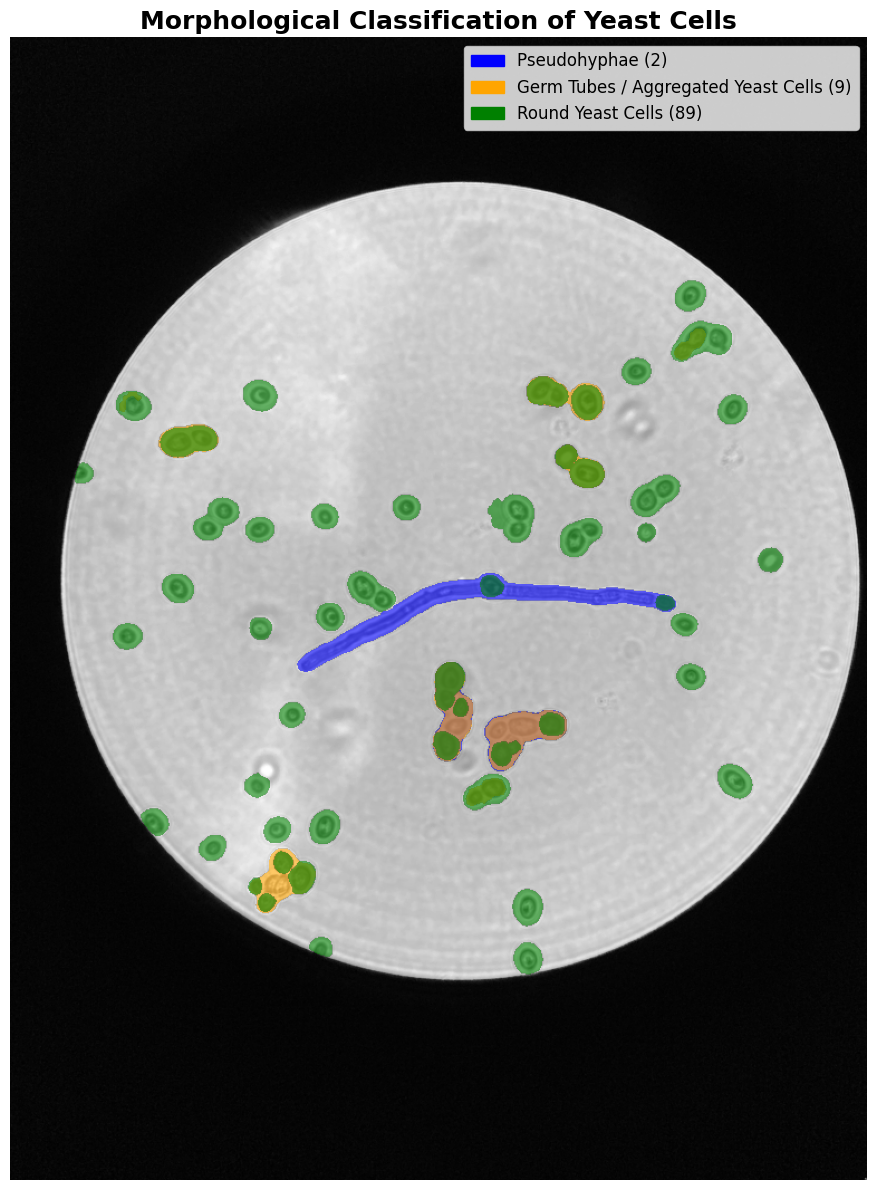

In [73]:
yeast, germ_tubes, pseudohyphae = morphological_classification(results)